In [ ]:

#1 Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

sns.set(style='whitegrid')


In [ ]:

#2 Load dataset (ensure file exists at this path)

df = pd.read_csv('Project1WeatherDataset.csv')
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (8784, 8)


,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [ ]:
#3 Basic checks about data
print(df.info())
print('\nMissing values per column:\n', df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date/Time         8784 non-null   object 
 1   Temp_C            8784 non-null   float64
 2   Dew Point Temp_C  8784 non-null   float64
 3   Rel Hum_%         8784 non-null   int64  
 4   Wind Speed_km/h   8784 non-null   int64  
 5   Visibility_km     8784 non-null   float64
 6   Press_kPa         8784 non-null   float64
 7   Weather           8784 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 549.1+ KB
None

Missing values per column:
 Date/Time           0
Temp_C              0
Dew Point Temp_C    0
Rel Hum_%           0
Wind Speed_km/h     0
Visibility_km       0
Press_kPa           0
Weather             0
dtype: int64


In [ ]:
#4 Try to pick a target column name heuristically
possible_targets = [c for c in df.columns if c.lower() in ['target','label','weather','rain','play','outcome','class','forecast']]
if len(possible_targets) == 0:
    target_col = df.columns[-1]
else:
    target_col = possible_targets[0]

print("Using target column:", target_col)

#5 Create X and y
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

#6 Encode target if needed
from sklearn.preprocessing import LabelEncoder
if y.dtype == 'object' or y.dtype.name == 'category':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    print("Target classes:", list(le_target.classes_))
else:
    print("Target value counts:\n", y.value_counts())

#7 Encode categorical features
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print("Categorical features:", cat_cols)
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

#8 Scale numeric features (trees don't need scaling but it's ok)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

#9 Convert to numpy arrays and split
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Using target column: Weather
Target classes: ['Clear', 'Cloudy', 'Drizzle', 'Drizzle,Fog', 'Drizzle,Ice Pellets,Fog', 'Drizzle,Snow', 'Drizzle,Snow,Fog', 'Fog', 'Freezing Drizzle', 'Freezing Drizzle,Fog', 'Freezing Drizzle,Haze', 'Freezing Drizzle,Snow', 'Freezing Fog', 'Freezing Rain', 'Freezing Rain,Fog', 'Freezing Rain,Haze', 'Freezing Rain,Ice Pellets,Fog', 'Freezing Rain,Snow Grains', 'Haze', 'Mainly Clear', 'Moderate Rain,Fog', 'Moderate Snow', 'Moderate Snow,Blowing Snow', 'Mostly Cloudy', 'Rain', 'Rain Showers', 'Rain Showers,Fog', 'Rain Showers,Snow Showers', 'Rain,Fog', 'Rain,Haze', 'Rain,Ice Pellets', 'Rain,Snow', 'Rain,Snow Grains', 'Rain,Snow,Fog', 'Rain,Snow,Ice Pellets', 'Snow', 'Snow Pellets', 'Snow Showers', 'Snow Showers,Fog', 'Snow,Blowing Snow', 'Snow,Fog', 'Snow,Haze', 'Snow,Ice Pellets', 'Thunderstorms', 'Thunderstorms,Heavy Rain Showers', 'Thunderstorms,Moderate Rain Showers,Fog', 'Thunderstorms,Rain', 'Thunderstorms,Rain Showers', 'Thunderstorms,Rain Showers,Fog

In [ ]:

#10 Manual CART (Gini impurity-based) - simple implementation
import numpy as np
from collections import Counter

def gini(y):
    m = len(y)
    if m == 0:
        return 0
    counts = np.bincount(y)
    probs = counts / m
    return 1 - np.sum(probs**2)

def split(X, y, feature, thr):
    left_idx = X[:, feature] <= thr
    right_idx = ~left_idx
    return X[left_idx], y[left_idx], X[right_idx], y[right_idx]

def best_split(X, y):
    n_samples, n_features = X.shape
    best_feature, best_thr, best_gain = None, None, 0
    parent_gini = gini(y)
    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for thr in thresholds:
            X_l, y_l, X_r, y_r = split(X, y, feature, thr)
            if len(y_l) == 0 or len(y_r) == 0:
                continue
            g_l, g_r = gini(y_l), gini(y_r)
            weighted = (len(y_l)/n_samples)*g_l + (len(y_r)/n_samples)*g_r
            gain = parent_gini - weighted
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_thr = thr
    return best_feature, best_thr, best_gain

class Node:
    def __init__(self, feature=None, thr=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.thr = thr
        self.left = left
        self.right = right
        self.value = value

class CART:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def build(self, X, y, depth=0):
        n_samples, n_features = X.shape
        num_per_class = [np.sum(y==i) for i in range(len(np.unique(y)))]
        predicted = np.argmax(num_per_class)
        node = Node(value=predicted)

        if depth < self.max_depth and n_samples >= self.min_samples_split and len(np.unique(y))>1:
            feat, thr, gain = best_split(X, y)
            if feat is not None and gain>0:
                X_l, y_l, X_r, y_r = split(X, y, feat, thr)
                node = Node(feature=feat, thr=thr)
                node.left = self.build(X_l, y_l, depth+1)
                node.right = self.build(X_r, y_r, depth+1)
                return node
        node.value = predicted
        return node

    def fit(self, X, y):
        self.root = self.build(X, y)

    def _predict(self, x):
        node = self.root
        while node.left is not None:
            if x[node.feature] <= node.thr:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

#11 Train manual CART
manual_cart = CART(max_depth=6, min_samples_split=5)
manual_cart.fit(X_train, y_train)
y_pred_manual = manual_cart.predict(X_test)

#12 Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
acc_manual = accuracy_score(y_test, y_pred_manual)
prec_manual = precision_score(y_test, y_pred_manual, average='weighted', zero_division=0)
rec_manual = recall_score(y_test, y_pred_manual, average='weighted', zero_division=0)
f1_manual = f1_score(y_test, y_pred_manual, average='weighted', zero_division=0)

print('Manual CART -> Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(acc_manual, prec_manual, rec_manual, f1_manual))

Manual CART -> Accuracy: 0.271, Precision: 0.102, Recall: 0.271, F1: 0.148


## 🤖 Scikit-learn DecisionTreeClassifier

In [ ]:

#13 Train sklearn DecisionTreeClassifier (CART with Gini)
from sklearn.tree import DecisionTreeClassifier, plot_tree
sk_cart = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_split=5, random_state=42)
sk_cart.fit(X_train, y_train)
y_pred_sk = sk_cart.predict(X_test)

acc_sk = accuracy_score(y_test, y_pred_sk)
prec_sk = precision_score(y_test, y_pred_sk, average='weighted', zero_division=0)
rec_sk = recall_score(y_test, y_pred_sk, average='weighted', zero_division=0)
f1_sk = f1_score(y_test, y_pred_sk, average='weighted', zero_division=0)

print('Sklearn CART -> Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(acc_sk, prec_sk, rec_sk, f1_sk))


Sklearn CART -> Accuracy: 0.404, Precision: 0.390, Recall: 0.404, F1: 0.391


In [ ]:

#14 Comparison table
import pandas as pd
comp = pd.DataFrame({
    'Metric': ['Accuracy','Precision','Recall','F1'],
    'Manual_CART': [acc_manual, prec_manual, rec_manual, f1_manual],
    'Sklearn_CART': [acc_sk, prec_sk, rec_sk, f1_sk]
})
comp


,Metric,Manual_CART,Sklearn_CART
0,Accuracy,0.271485,0.403529
1,Precision,0.102004,0.390310
2,Recall,0.271485,0.403529
3,F1,0.147845,0.391234


In [ ]:
#15 Get value counts of the original target variable
target_value_counts = df[target_col].value_counts()
display(target_value_counts.head(10))


,count
Weather,
Mainly Clear,2106
Mostly Cloudy,2069
Cloudy,1728
Clear,1326
Snow,390
Rain,306
Rain Showers,188
Fog,150
"Rain,Fog",116


/tmp/ipython-input-234997946.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_value_counts.head(10).index, y=target_value_counts.head(10).values, palette='viridis')


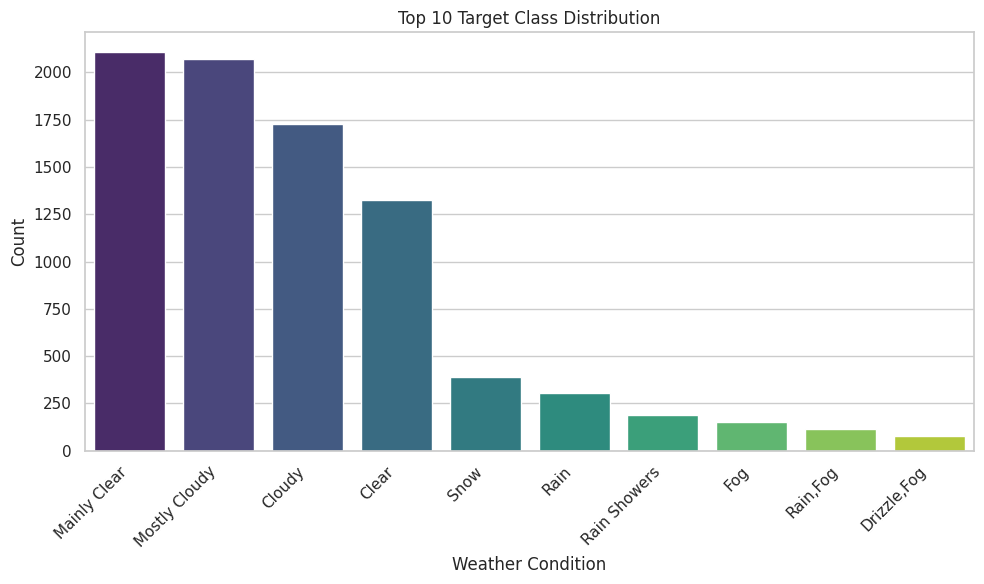

In [ ]:


#16 Plot the distribution of the top 10 target classes
plt.figure(figsize=(10, 6))
sns.barplot(x=target_value_counts.head(10).index, y=target_value_counts.head(10).values, palette='viridis')
plt.title('Top 10 Target Class Distribution')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [ ]:
#17 Also show the number of unique classes and the least frequent ones
print(f"Total unique classes: {len(target_value_counts)}")
print("Least frequent classes (bottom 5):")
display(target_value_counts.tail(5))

Total unique classes: 50
Least frequent classes (bottom 5):


,count
Weather,
Snow Pellets,1
"Rain Showers,Fog",1
"Drizzle,Ice Pellets,Fog",1
"Rain,Ice Pellets",1
"Rain,Snow Grains",1


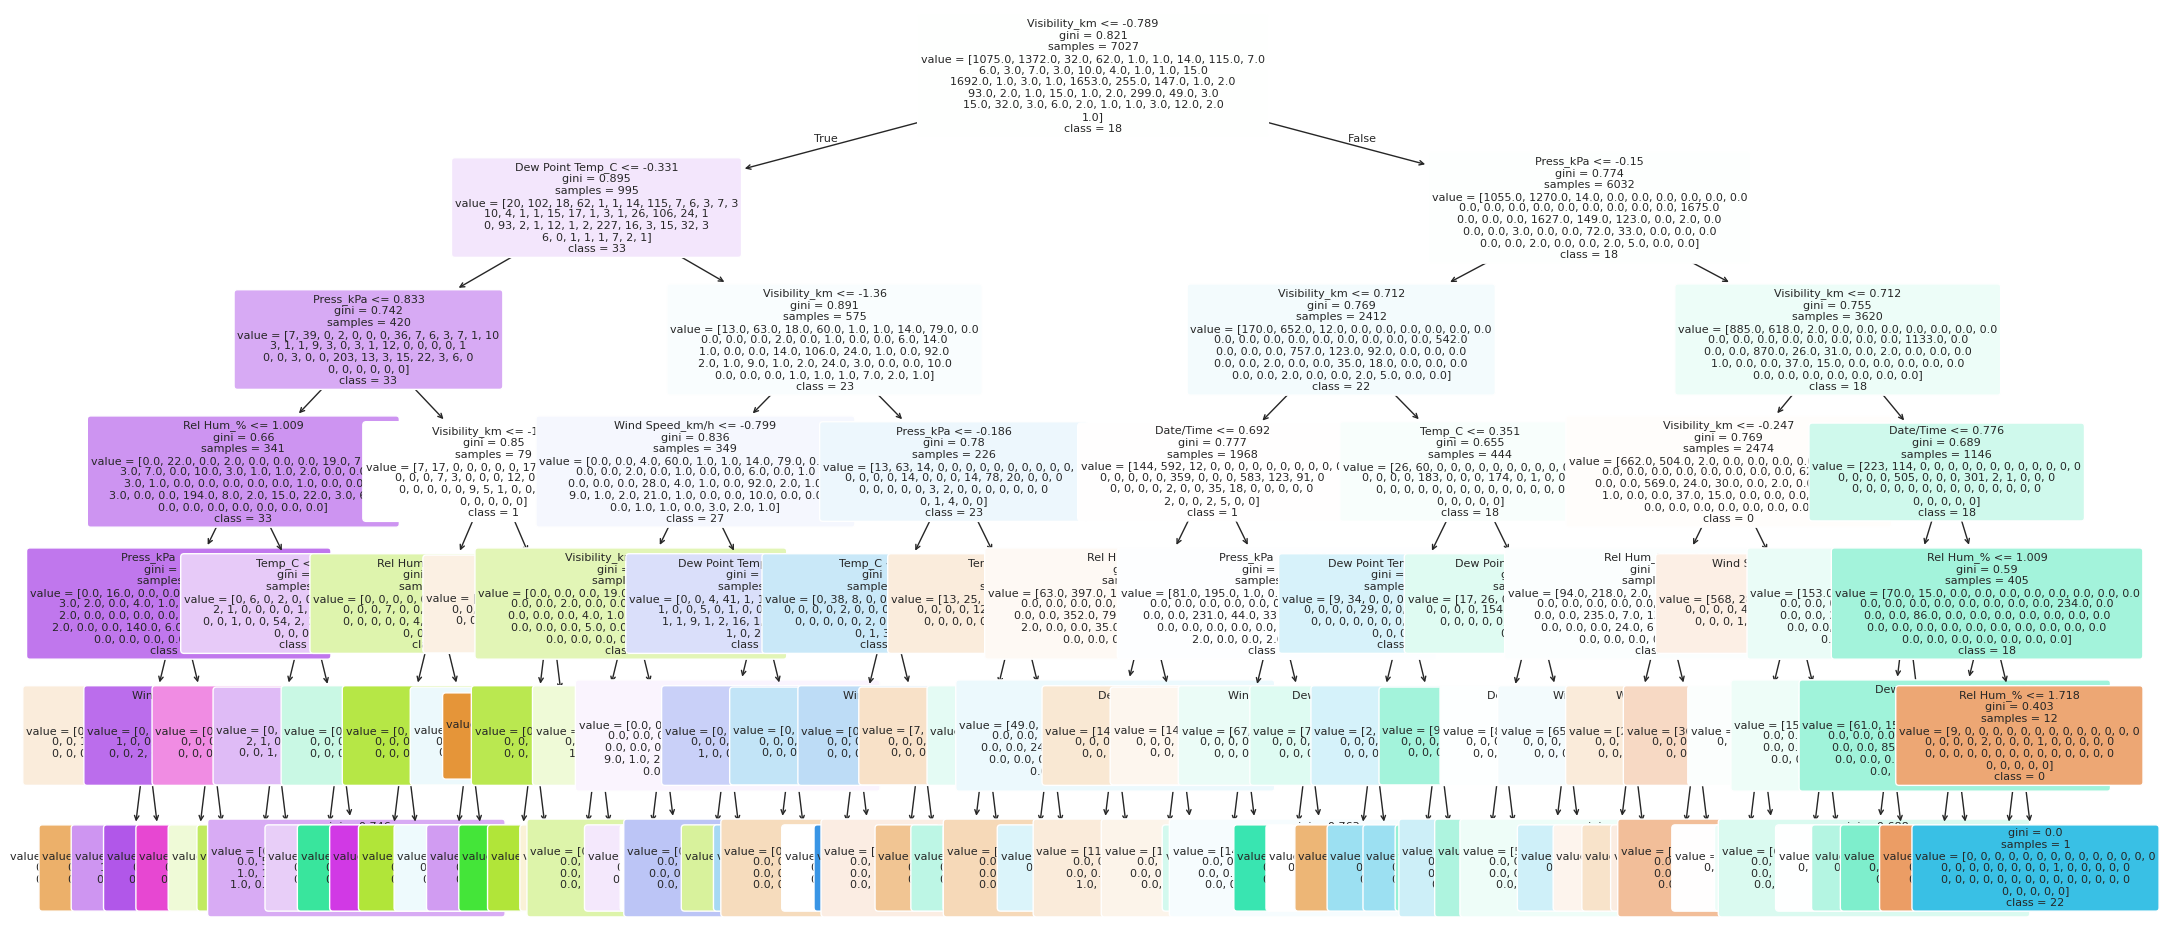

In [ ]:

#18 Plot sklearn tree (visualization)
plt.figure(figsize=(25,12))
plot_tree(sk_cart,filled=True, feature_names=list(df.drop(columns=[target_col]).columns), class_names=[str(c) for c in np.unique(y)], fontsize=8, rounded=True)
plt.show()
